In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Normalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


Load data


In [2]:
# Carregar o CSV
df = pd.read_csv("dados_reais_e_simulados.csv", sep=";", decimal=".", dtype=float)

# Dividir os dados em treino (80%) e teste (20%)
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Visualizar os dados de treino
# train_df.head()
# test_df.head()
# print(train_df)
df.head()

,vel,FRH,RRH,vol_pos,AoD,AoT,ClA,CdA,Cpz,DD,DE,m
0,36.388116,40.324819,47.620792,-12.749703,0.993837,0.753301,2.862229,1.319733,160.348,13.231,13.231,56.831
1,37.531006,52.075444,47.519999,5.628627,1.739537,1.479083,2.946743,1.383392,151.794,13.861,13.861,70.544
2,41.261859,43.545078,44.095291,-7.668691,-0.407964,0.236992,2.902311,1.287926,168.855,10.793,10.793,71.502
3,41.503753,44.698525,49.650558,-5.663685,1.558956,1.002525,2.920256,1.344202,176.472,14.595,14.595,78.007
4,44.821902,42.713296,43.402069,3.083435,1.000266,0.226274,2.904481,1.311804,188.754,13.405,13.405,90.632


Pre Processing

In [3]:
inputs = ["vel", "FRH", "RRH", "vol_pos", "AoD", "AoT"]
outputs = ["ClA", "CdA", "Cpz", "DD", "DE", "m"]

# Definir os dados de entrada e saída
x = df[inputs].values
y = df[outputs].values

# Definir os dados de teste
# x1 = test_df[inputs].values
# y1 = test_df[outputs].values

# Normalizar os dados de entrada
x_norm = Normalization(input_dim=len(inputs))
x_norm.adapt(x)

# Normalizar os dados de saída
y_scaler = StandardScaler()
y_scaler.fit(y)
y_scaled = y_scaler.transform(y)
# y1_scaled = y_scaler.transform(y1)

print(x.shape)
print(y.shape)
# print(x1.shape)
# print(y1.shape)

(99, 6)
(99, 6)


c:\Users\pc\Desktop\arnaldo\.venv\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train Model


🔁 Fold 1/5


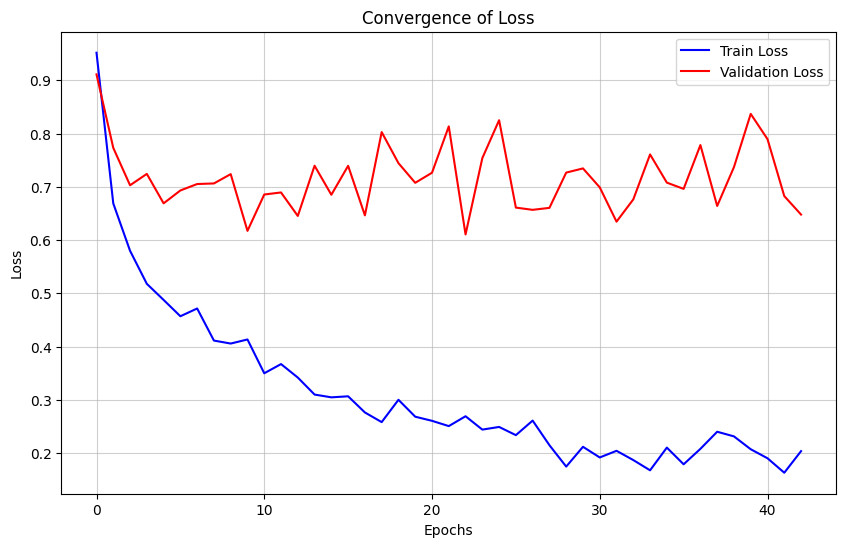

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
✔ Fold 1 — MSE: 0.5527 | R²: 0.5070 | MAE: 0.5516

🔁 Fold 2/5


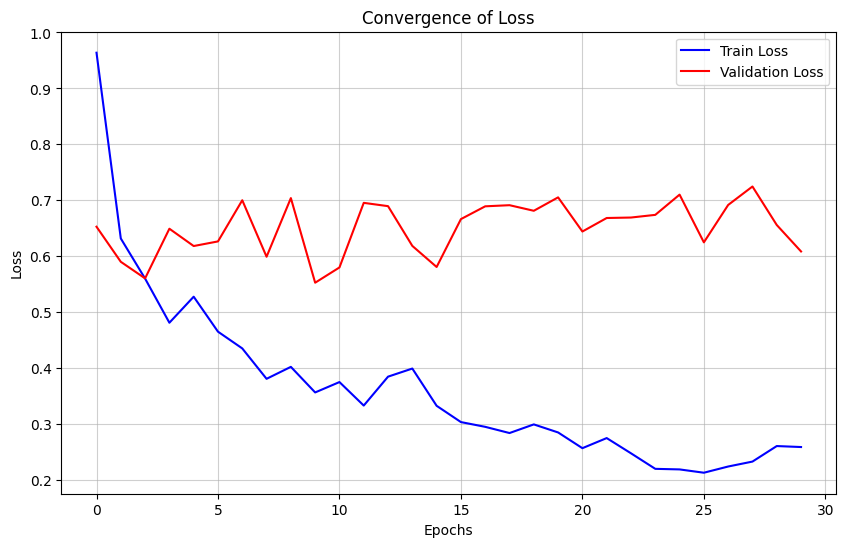

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
✔ Fold 2 — MSE: 0.4979 | R²: 0.4562 | MAE: 0.5107

🔁 Fold 3/5


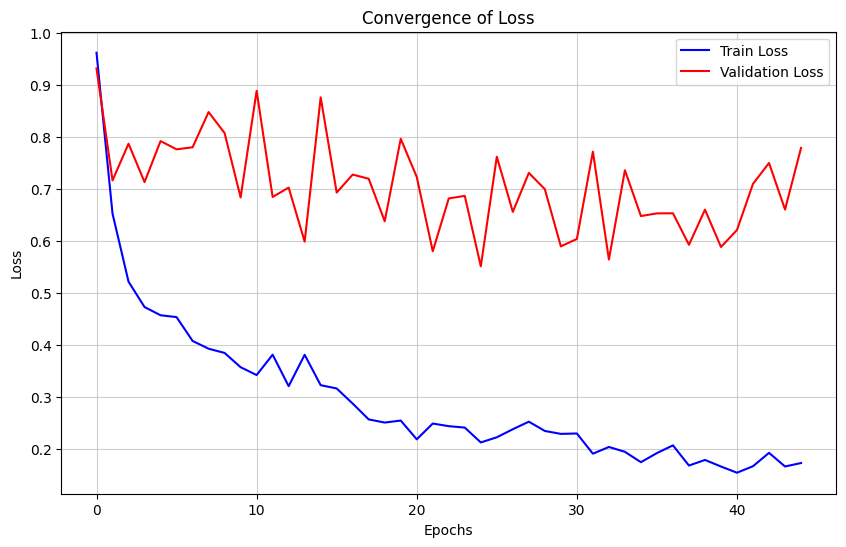

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
✔ Fold 3 — MSE: 0.4972 | R²: 0.5216 | MAE: 0.5070

🔁 Fold 4/5


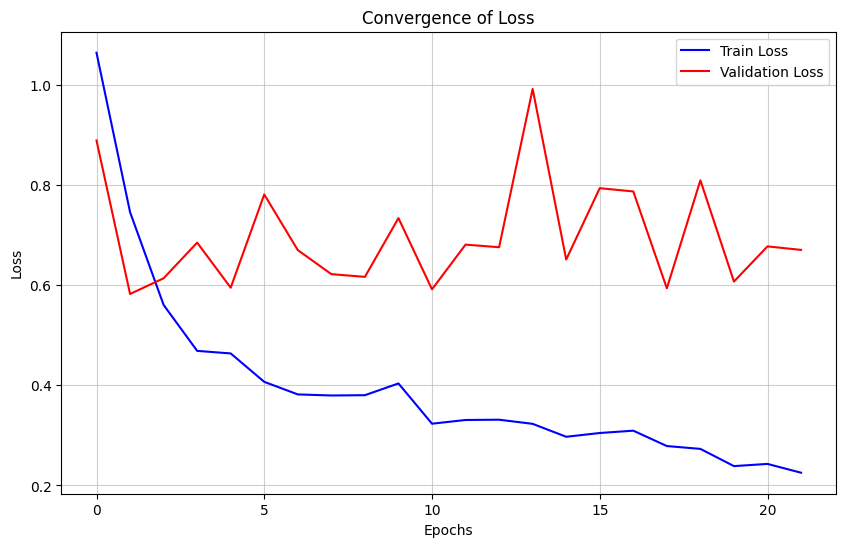

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
✔ Fold 4 — MSE: 0.5243 | R²: -0.2080 | MAE: 0.5461

🔁 Fold 5/5


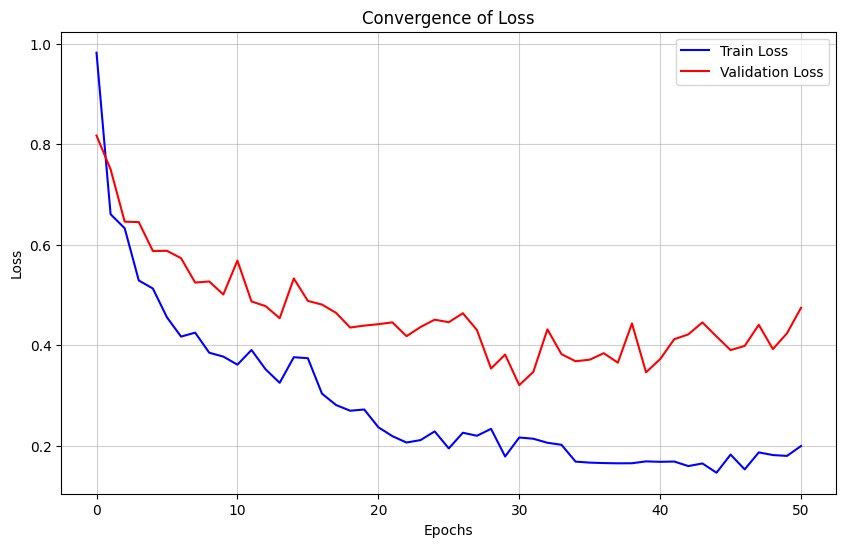

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
✔ Fold 5 — MSE: 0.2664 | R²: 0.7253 | MAE: 0.4021

📊 Resultados Médios:
✅ MSE médio: 0.4677
✅ R² médio: 0.4004
✅ MAE médio: 0.5035


In [4]:
# Função para criar o modelo
def create_model(x_train, output_dim):
    x_norm = Normalization()
    x_norm.adapt(x_train)

    model = Sequential(
        [
            x_norm,
            Dense(40, activation="relu", kernel_regularizer=l2(0.001)),
            Dropout(0.1),
            Dense(60, activation="relu", kernel_regularizer=l2(0.001)),
            Dropout(0.1),
            Dense(40, activation="relu"),
            Dense(output_dim),
        ]
    )

    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae", "mse", "r2_score"])

    return model


# K-Fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

mse_scores, r2_scores, mae_scores = [], [], []

for fold, (train_index, val_index) in enumerate(kf.split(x)):
    print(f"\n🔁 Fold {fold + 1}/{k}")

    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y_scaled[train_index], y_scaled[val_index]

    # Criar modelo
    model = create_model(x_train, output_dim=len(outputs))

    import os

    # Ensure the directory exists
    model_dir = "models"
    os.makedirs(model_dir, exist_ok=True)
    callbacks = [
        EarlyStopping(monitor="val_loss", mode="min", patience=20, restore_best_weights=True, verbose=0),
        ModelCheckpoint(
            filepath=os.path.join(model_dir, f"model_fold{fold + 1}.keras"),
            monitor="val_loss",
            save_best_only=True,
            verbose=0,
        ),
    ]

    hist = model.fit(
        x_train,
        y_train,
        batch_size=8,
        epochs=200,
        validation_data=(x_val, y_val),
        callbacks=callbacks,
        verbose=0,
        shuffle=True,
    )

    plt.figure(figsize=(10, 6))

    # Plota a perda (loss) nos dados de treinamento
    plt.plot(hist.history["loss"], label="Train Loss", color="blue")

    # Plota a perda (loss) nos dados de validação
    plt.plot(hist.history["val_loss"], label="Validation Loss", color="red")

    # Adiciona títulos e legendas para clareza
    plt.title("Convergence of Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.6)

    # Mostra o gráfico
    plt.show()

    # Avaliação
    y_pred = model.predict(x_val)
    mse = mean_squared_error(y_val, y_pred, multioutput="uniform_average")
    r2 = r2_score(y_val, y_pred, multioutput="uniform_average")
    mae = mean_absolute_error(y_val, y_pred, multioutput="uniform_average")

    print(f"✔ Fold {fold + 1} — MSE: {mse:.4f} | R²: {r2:.4f} | MAE: {mae:.4f}")

    mse_scores.append(mse)
    r2_scores.append(r2)
    mae_scores.append(mae)

# Resultados finais
print("\n📊 Resultados Médios:")
print(f"✅ MSE médio: {np.mean(mse_scores):.4f}")
print(f"✅ R² médio: {np.mean(r2_scores):.4f}")
print(f"✅ MAE médio: {np.mean(mae_scores):.4f}")

ENSEMBLE PREDICTIONS

In [5]:
from tensorflow.keras.models import load_model
import numpy as np

models = [load_model(f"models/model_fold{i + 1}.keras") for i in range(k)]


def predict_with_ensemble(x_input):
    preds = [model.predict(x_input) for model in models]
    return np.mean(preds, axis=0)  # média das previsões

In [6]:
# model = Sequential([
#     x_norm,
#     Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),
#     Dropout(0.1),
#     Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),
#     Dropout(0.1),
#     Dense(32, activation='relu'),
#     Dense(len(outputs))
# ])

# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])
# model.summary()

# # Callbacks com validação
# callbacks = [
#     EarlyStopping(monitor="val_loss", mode="min", patience=500, restore_best_weights=True, verbose=1),
#     ModelCheckpoint(filepath=r"C:\Users\pc\OneDrive\Documentos\Fórmula\Mpa\Mapa\Mapa 2025\Códigos\model1.keras", monitor="val_loss", save_best_only=True, verbose=1),
# ]

# # Treinamento com divisão de validação
# hist = model.fit(
#     x, y_scaled,
#     batch_size=64,
#     epochs=2000,
#     validation_split=0.2,  # Essa linha ativa a validação automática
#     callbacks=callbacks,
#     verbose=1,
#     shuffle=True
# )

In [7]:
# plt.plot(hist.history["val_loss"])

In [8]:
# y1_pred_scaled = model.predict(x1)
# y1_pred = y_scaler.inverse_transform(y1_pred_scaled)
# y1_real = y1  # já está em escala original

# # Exemplo de métrica
# from sklearn.metrics import mean_absolute_error
# print("MAE no teste:", mean_absolute_error(y1_real, y1_pred))

# # Predição nos dados de teste
# y1_pred_scaled = model.predict(x1)
# y1_pred = y_scaler.inverse_transform(y1_pred_scaled)

# # Avaliar erro
# from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

# print("MAE:", mean_absolute_error(y1, y1_pred))
# print("RMSE:", root_mean_squared_error(y1, y1_pred))
# print("R²:", r2_score(y1, y1_pred))

METRICS

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

vars_y_true = np.hsplit(y_scaled, len(outputs))
vars_y_pred = np.hsplit(predict_with_ensemble(x), len(outputs))

metrics = dict(mse=mean_squared_error, mae=mean_absolute_error, r2=r2_score)

for y_true, y_pred, name in zip(vars_y_true, vars_y_pred, outputs):
    y_true = y_true.ravel()  # Flatten to 1D
    y_pred = y_pred.ravel()  # Flatten to 1D
    for metric_name, metric_fn in metrics.items():
        print(f"{name} - {metric_name}: {metric_fn(y_true, y_pred):.3f}")
    print()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
ClA - mse: 0.281
ClA - mae: 0.430
ClA - r2: 0.719

CdA - mse: 0.260
CdA - mae: 0.419
CdA - r2: 0.740

Cpz - mse: 0.233
Cpz - mae: 0.387
Cpz - r2: 0.767

DD - mse: 0.057
DD - mae: 0.187
DD - r2: 0.943

DE - mse: 0.059
DE - mae: 0.179
DE - r2: 0.941

m - mse: 0.066
m - mae: 0.202
m - r2: 0.934



In [10]:
# vars_y1_true = np.hsplit(y1_scaled, len(outputs))
# vars_y1_pred = np.hsplit(model.predict(x1), len(outputs))

# metrics = dict(mse=mean_squared_error, mae=mean_absolute_error, r2=r2_score)

# for y1_true, y1_pred, name in zip(vars_y1_true, vars_y1_pred, outputs):
#     y1_true = y1_true.ravel()  # Flatten to 1D
#     y1_pred = y1_pred.ravel()  # Flatten to 1D
#     for metric_name, metric_fn in metrics.items():
#         print(f"{name} - {metric_name}: {metric_fn(y1_true, y1_pred):.3f}")
#     print()

PREDICTIONS

ONE SAMPLE

In [11]:
input_sample = x[0]
output_sample = y[0]
print("input:", input_sample)

y_pred = predict_with_ensemble(np.expand_dims(input_sample, axis=0))
y_pred = y_scaler.inverse_transform(y_pred)
print("output real:", output_sample)
print("output pred:", y_pred[0])

input: [ 36.3881159   40.3248191   47.62079159 -12.74970307   0.99383669
   0.75330098]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
output real: [  2.8622295    1.31973338 160.348       13.231       13.231
  56.831     ]
output pred: [  2.8218896   1.2991256 199.18571    11.647377   12.3310795  83.04929  ]


In [12]:
input_sample = [60, 45.0, 40.0, 0, 0, 0]
print("input:", input_sample)

y_pred = predict_with_ensemble(np.expand_dims(input_sample, axis=0))
y_pred = y_scaler.inverse_transform(y_pred)
print("output pred:", y_pred[0])

input: [60, 45.0, 40.0, 0, 0, 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
output pred: [  2.7657819   1.2721435 206.56824    17.992807   18.265852  177.0256   ]


MULTIPLE SAMPLES

In [13]:
y_pred = predict_with_ensemble(x)
y_pred = y_scaler.inverse_transform(y_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [14]:
df_true = pd.DataFrame(y, columns=outputs)
df_pred = pd.DataFrame(y_pred, columns=[f"{name}_pred" for name in outputs])

df_res = pd.concat([df_true, df_pred], axis=1)
df_res.to_csv("Resultados.csv", index=False)
df_res.head()

,ClA,CdA,Cpz,DD,DE,m,ClA_pred,CdA_pred,Cpz_pred,DD_pred,DE_pred,m_pred
0,2.862229,1.319733,160.348,13.231,13.231,56.831,2.821890,1.299126,199.185715,11.647376,12.331079,83.049301
1,2.946743,1.383392,151.794,13.861,13.861,70.544,2.735694,1.325657,204.056839,14.155461,13.065727,105.197563
2,2.902311,1.287926,168.855,10.793,10.793,71.502,2.784714,1.280908,201.748230,12.403747,13.549503,106.757683
3,2.920256,1.344202,176.472,14.595,14.595,78.007,2.810092,1.312345,198.102112,14.502082,14.340292,105.722450
4,2.904481,1.311804,188.754,13.405,13.405,90.632,2.758247,1.280034,218.291519,14.320655,13.780631,121.380127


In [15]:
# y1_pred = model.predict(x1)
# y1_pred = y_scaler.inverse_transform(y1_pred)


# df_true_test = pd.DataFrame(y1, columns=outputs)
# df_pred_test = pd.DataFrame(y1_pred, columns=[f"{name}_pred" for name in outputs])

# df_res_test = pd.concat([df_true_test, df_pred_test], axis=1)
# #df_res_test.to_csv(r"C:\Users\juans\Desktop\Fórmula\Mapa 2025\Códigos\resultados_teste.csv", index=False)
# df_res_test.head()


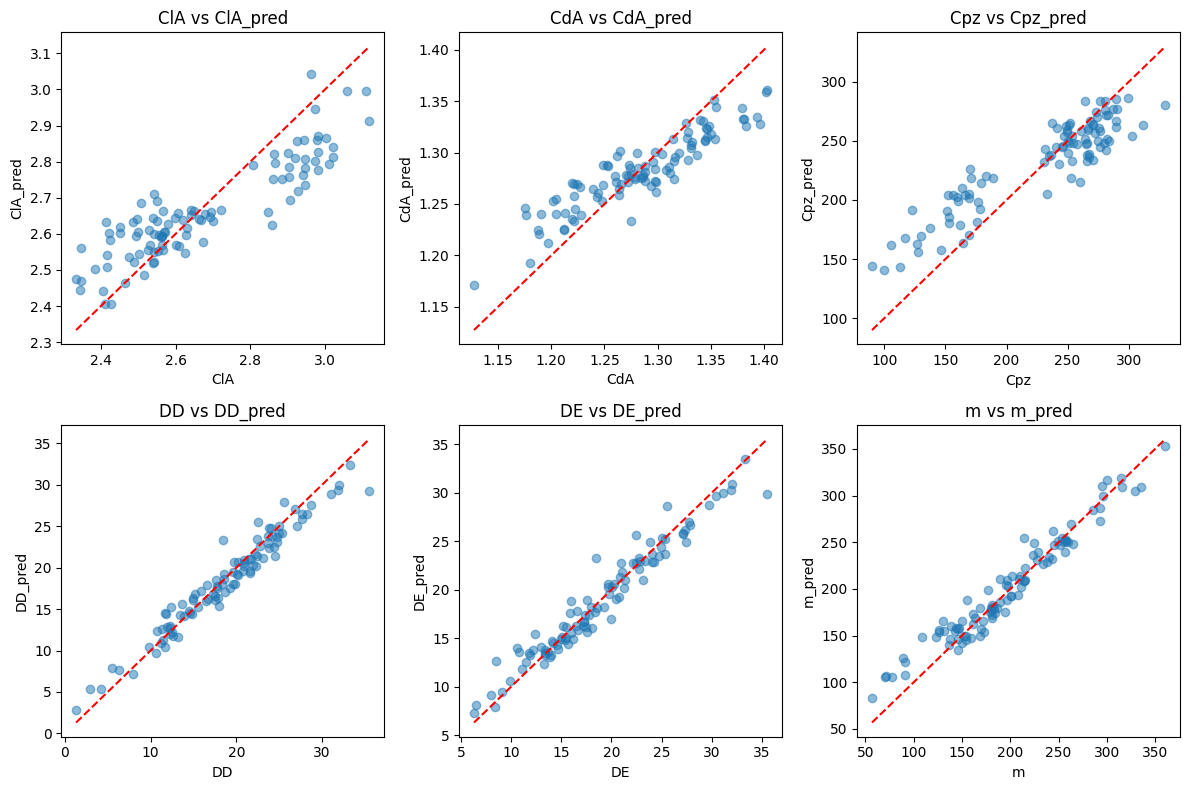

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Define número de colunas e calcula número de linhas necessárias
num_outputs = len(outputs)
cols = 3  # por exemplo, 5 gráficos por linha
rows = int(np.ceil(num_outputs / cols))

# Cria uma figura com subplots organizados
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  # tamanho uniforme

# Se axes for 1D, converte para 2D para evitar erro de indexação
axes = axes.flatten()

# Plota os gráficos
for i, name in enumerate(outputs):
    ax = axes[i]
    ax.scatter(df_res[name], df_res[f"{name}_pred"], alpha=0.5)
    ax.plot([df_res[name].min(), df_res[name].max()], [df_res[name].min(), df_res[name].max()], "r--")
    ax.set_title(f"{name} vs {name}_pred")
    ax.set_xlabel(name)
    ax.set_ylabel(f"{name}_pred")

# Remove subplots vazios (se houver)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [17]:
import joblib

# Salvar o modelo treinado
# model.save('modelo_aerodinamico.h5')

# Salvar APENAS o scaler das SAÍDAS (y)
# (Certifique-se que a variável 'scaler_y' tem esse nome no seu código)
joblib.dump(y_scaler, "scaler_y.pkl")

print("Modelo e scaler de saída foram salvos com sucesso!")

Modelo e scaler de saída foram salvos com sucesso!
